<a href="https://colab.research.google.com/github/Jaime-Simoes/DL_project/blob/main/pics_and_split.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
# to put all the imports necessary

import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import requests
import os
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from multiprocessing import Pool
from google.colab import files
import logging
import time
from google.colab import drive
import zipfile
from PIL import Image
import matplotlib.pyplot as plt
import re

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import filters
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam

In [2]:
df = pd.read_csv('fitzpatrick17k.csv')

In [3]:
# get names of columns

columns = df.columns.tolist()
print(columns)

['md5hash', 'fitzpatrick_scale', 'fitzpatrick_centaur', 'label', 'nine_partition_label', 'three_partition_label', 'qc', 'url', 'url_alphanum']


In [4]:
print(len(df))      # amount of occurences

16577


In [5]:
df.isnull().sum()     # missing values

md5hash                      0
fitzpatrick_scale            0
fitzpatrick_centaur          0
label                        0
nine_partition_label         0
three_partition_label        0
qc                       16073
url                         41
url_alphanum                 0
dtype: int64

In [6]:
df.isna().sum()

md5hash                      0
fitzpatrick_scale            0
fitzpatrick_centaur          0
label                        0
nine_partition_label         0
three_partition_label        0
qc                       16073
url                         41
url_alphanum                 0
dtype: int64

In [7]:
print(df.duplicated(subset=['md5hash']).sum())

# First column has no repeated values. It's codes of some sort to identify each occurence.
# So we can delete this column.

0


In [8]:
df.drop(columns=['md5hash'], inplace=True)

In [9]:
# qc might be quality control

In [10]:
print(df['qc'].value_counts())     # numbers before are part of the names

# need to discuss this, not sure what's going on

1 Diagnostic          348
5 Potentially          97
2 Characteristic       32
3 Wrongly labelled     17
4 Other                10
Name: qc, dtype: int64


In [11]:
print(df['label'].value_counts())      # our target variable. lenght = 114 ;

psoriasis                      653
squamous cell carcinoma        581
lichen planus                  491
basal cell carcinoma           468
allergic contact dermatitis    430
                              ... 
port wine stain                 59
erythema elevatum diutinum      55
pustular psoriasis              53
xanthomas                       53
pilomatricoma                   53
Name: label, Length: 114, dtype: int64


In [12]:
duplicate_url = df.duplicated(subset=['url'])
print(duplicate_url.value_counts())

# 40 url repeat. Let's see if the whole line is equal (except 1st column that is some weird code)

False    16537
True        40
dtype: int64


In [13]:
print(df.iloc[:, 1:].duplicated().sum())     # duplicate rows except first column

# so there are 40 repeated url but no repeated rows. Meaning equal pictures have
# different attributes. need to discuss this.

0


In [14]:
print(df.iloc[:, [i for i in range(len(df.columns)) if i not in [0, 6]]].duplicated().sum())

0


In [15]:
print(df['nine_partition_label'].value_counts())
# categorize skin conditions by 9

inflammatory                    10886
malignant epidermal              1352
genodermatoses                   1194
benign dermal                    1067
benign epidermal                  931
malignant melanoma                573
benign melanocyte                 236
malignant cutaneous lymphoma      182
malignant dermal                  156
Name: nine_partition_label, dtype: int64


In [16]:
print(df['three_partition_label'].value_counts())
# categorize skin conditions by 3

non-neoplastic    12080
malignant          2263
benign             2234
Name: three_partition_label, dtype: int64


In [17]:
# Get distributions of numerical columns

In [18]:
# "fitzpatrick_scale" -> classification system used to categorize human skin color based on its response to sun exposure or UV light.
# Scale is from 1 to 6. (-1) instances are missing values.

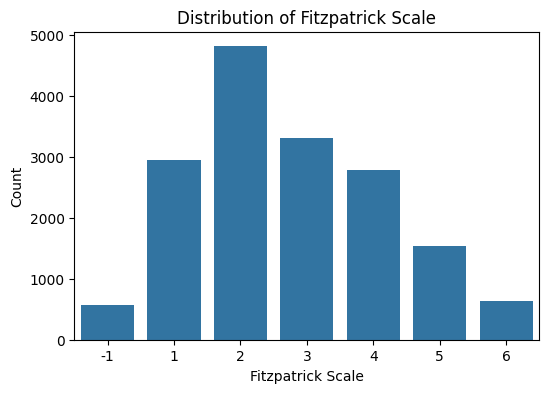

In [19]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='fitzpatrick_scale')
plt.title('Distribution of Fitzpatrick Scale')
plt.xlabel('Fitzpatrick Scale')
plt.ylabel('Count')
plt.show()

In [20]:
# Need to discuss what to do with these missing values!

In [21]:
missing_fitzscale = df[df['fitzpatrick_scale'] == -1]
print(missing_fitzscale['fitzpatrick_centaur'].value_counts())

# big correlation between missing values of fitz columns. The other values follow the
# reference distribution, aka proportional to existing values.

-1    291
 2     87
 1     75
 4     34
 3     33
 5     31
 6     14
Name: fitzpatrick_centaur, dtype: int64


In [22]:
print(missing_fitzscale['nine_partition_label'].value_counts())

# Here is a bit off but not mutch.

inflammatory                    359
malignant epidermal              65
benign dermal                    49
genodermatoses                   29
malignant melanoma               27
benign epidermal                 22
malignant cutaneous lymphoma      6
malignant dermal                  5
benign melanocyte                 3
Name: nine_partition_label, dtype: int64


In [23]:
print(missing_fitzscale['three_partition_label'].value_counts())

# Also different.

non-neoplastic    388
malignant         103
benign             74
Name: three_partition_label, dtype: int64


In [24]:
# "fitzpatrick_centaur" -> don't know what this is. Most likely (-1) are also missing values.

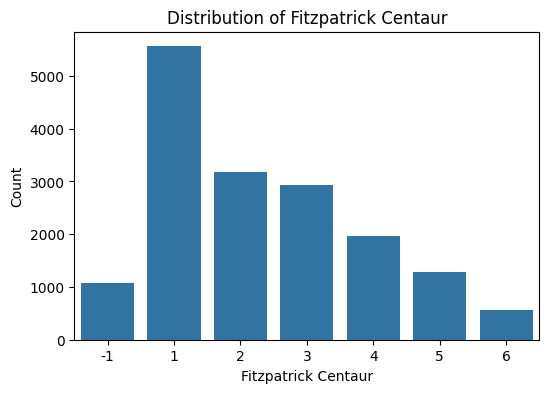

In [25]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='fitzpatrick_centaur')
plt.title('Distribution of Fitzpatrick Centaur')
plt.xlabel('Fitzpatrick Centaur')
plt.ylabel('Count')
plt.show()

In [26]:
# Need to discuss what to do with these missing values!

In [27]:
missing_fitzcentaur = df[df['fitzpatrick_centaur'] == -1]
print(missing_fitzcentaur['nine_partition_label'].value_counts())

# Different from scale column.

inflammatory                    661
benign dermal                   159
malignant epidermal             122
benign epidermal                 52
malignant melanoma               31
genodermatoses                   26
malignant dermal                 11
benign melanocyte                10
malignant cutaneous lymphoma      1
Name: nine_partition_label, dtype: int64


In [28]:
print(missing_fitzcentaur['three_partition_label'].value_counts())

non-neoplastic    687
benign            221
malignant         165
Name: three_partition_label, dtype: int64


In [29]:
# Now let's apply one hot encoding for categorical variables

In [30]:
one_hot_encode = ["nine_partition_label", "three_partition_label"]

new_df = pd.get_dummies(df, columns=one_hot_encode)

In [31]:
new_df.head()

,fitzpatrick_scale,fitzpatrick_centaur,label,qc,url,url_alphanum,nine_partition_label_benign dermal,nine_partition_label_benign epidermal,nine_partition_label_benign melanocyte,nine_partition_label_genodermatoses,nine_partition_label_inflammatory,nine_partition_label_malignant cutaneous lymphoma,nine_partition_label_malignant dermal,nine_partition_label_malignant epidermal,nine_partition_label_malignant melanoma,three_partition_label_benign,three_partition_label_malignant,three_partition_label_non-neoplastic
0,3,3,drug induced pigmentary changes,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicmminoc...,0,0,0,0,1,0,0,0,0,0,0,1
1,1,1,photodermatoses,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicpphoto...,0,0,0,0,1,0,0,0,0,0,0,1
2,2,3,dermatofibroma,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicdderma...,1,0,0,0,0,0,0,0,0,1,0,0
3,1,1,psoriasis,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicppsori...,0,0,0,0,1,0,0,0,0,0,0,1
4,1,1,psoriasis,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicppsori...,0,0,0,0,1,0,0,0,0,0,0,1


In [32]:
new_df.shape

(16577, 18)

In [33]:
# This will give problems later on for sure but for now keep it like this. To apply CNN needs to be one hot encoded.

In [34]:
# Need to see if column "qc" is built in a certain specific way that makes sense. If not almost everything is missing values so it
# will be worse to keep it I think. Delete for now:

In [35]:
new_df.drop(columns=['qc'], inplace=True)

In [36]:
# Let's deal with the missing values in url. url_alphanum doesn't have any.

In [37]:
new_df['url'].fillna(df['url_alphanum'], inplace=True)

In [38]:
print(new_df['url'].isnull().sum())

0


In [39]:


# Filter rows where 'url' column has been filled with values from 'url_alphanum'
filled_rows = new_df['url'] == new_df['url_alphanum']
print(new_df.loc[filled_rows, 'url'])

145      httpwwwdermaamincomsiteimagesclinicalpicLLiche...
349      httpwwwdermaamincomsiteimagesclinicalpicooralm...
535      httpwwwdermaamincomsiteimagesclinicalpicLLiche...
868      httpwwwdermaamincomsiteimagesclinicalpicLLiche...
879      httpwwwdermaamincomsiteimagesclinicalpicooralm...
918      httpwwwdermaamincomsiteimagesclinicalpicLLiche...
1322     httpwwwdermaamincomsiteimagesclinicalpicLLiche...
1958     httpwwwdermaamincomsiteimageshistopicjjunction...
1972     httpwwwdermaamincomsiteimagesclinicalpicLLiche...
2078     httpwwwdermaamincomsiteimagesclinicalpicLLiche...
2519     httpwwwdermaamincomsiteimagesclinicalpicLLiche...
3601     httpwwwdermaamincomsiteimagesclinicalpicLLiche...
3672     httpwwwdermaamincomsiteimagesclinicalpicLLiche...
4267     httpwwwdermaamincomsiteimagesclinicalpicLLiche...
4426     httpwwwdermaamincomsiteimagesclinicalpicLLiche...
4795     httpwwwdermaamincomsiteimagesclinicalpicLLiche...
5410     httpwwwdermaamincomsiteimagesclinicalpicLLiche.

In [40]:
# Define the function to convert the URL
def convert_url(url):
    url = url.replace("httpwwwdermaamincom", "https://www.dermaamin.com")
    url = url.replace("siteimages", "site/images/")
    url = url.replace("clinicalpicLLichensimplexchronicusLichensimplexchronicus", "clinical-pic/l/lichensimplexchronicus/lichensimplexchronicus")
    url = url.replace("site/images/l/", "site/images/")
    url = url.replace("jpg.jpg", ".jpg")
    url = url.replace("jpg", "jpg")
    url = url.replace("com", "com/")
    return url

# Apply the conversion function to the filtered rows
df_3 = new_df.copy()  # Create a copy of the DataFrame to avoid modifying the original
df_3.loc[filled_rows, 'url'] = df_3.loc[filled_rows, 'url'].apply(convert_url)

# Print the modified 'url' column
print(df_3.loc[filled_rows, 'url'])

145      https://www.dermaamin.com/site/images/clinical...
349      https://www.dermaamin.com/site/images/clinical...
535      https://www.dermaamin.com/site/images/clinical...
868      https://www.dermaamin.com/site/images/clinical...
879      https://www.dermaamin.com/site/images/clinical...
918      https://www.dermaamin.com/site/images/clinical...
1322     https://www.dermaamin.com/site/images/clinical...
1958     https://www.dermaamin.com/site/images/histopic...
1972     https://www.dermaamin.com/site/images/clinical...
2078     https://www.dermaamin.com/site/images/clinical...
2519     https://www.dermaamin.com/site/images/clinical...
3601     https://www.dermaamin.com/site/images/clinical...
3672     https://www.dermaamin.com/site/images/clinical...
4267     https://www.dermaamin.com/site/images/clinical...
4426     https://www.dermaamin.com/site/images/clinical...
4795     https://www.dermaamin.com/site/images/clinical...
5410     https://www.dermaamin.com/site/images/clinical.

In [41]:
def download_image(image_url, file_place):
    """
    Downloads images from URLs.

    Inputs:
        image_url(str): URL of the image to download.
        file_place(str): Path where the downloaded image will be saved.

    Outputs:
        None.
    """
    # Step 1: Send a GET request to the provided image URL
    res = requests.get(image_url, stream=True, headers={'User-Agent': "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36"})

    # Step 2: Check if the request was successful (HTTP status code 200)
    if res.status_code == 200:
        # Step 3: If successful, open the file at the specified location in binary write mode
        with open(file_place, 'wb') as f:
          shutil.copyfileobj(res.raw, f) # Step 4: Copy the content of the response to the file
        # Step 5: Print the status of the download

    else:
        print("Image coulnd't be retrieved")

In [42]:
# Download locally so that you don't have to download everything every time you leave.

In [43]:
def download_image(image_url, file_place):
    """
    Downloads images from URLs.

    Inputs:
        image_url(str): URL of the image to download.
        file_place(str): Path where the downloaded image will be saved.

    Outputs:
        None.
    """
    try:
        # Create the output directory if it doesn't exist
        os.makedirs(os.path.dirname(file_place), exist_ok=True)

        # Send a GET request to the provided image URL
        res = requests.get(image_url, stream=True, headers={'User-Agent': "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36"})

        # Check if the request was successful (HTTP status code 200)
        if res.status_code == 200:
            # Open the file at the specified location in binary write mode
            with open(file_place, 'wb') as f:
                shutil.copyfileobj(res.raw, f)  # Copy the content of the response to the file

        else:
            print(f"Failed to download image from {image_url}")
    except Exception as e:
        print(f"Error downloading image from {image_url}: {e}")

In [44]:
'''
# Assuming df_3 is your DataFrame containing image URLs
url_column_name = 'url'
output_folder = 'images_DL'  # folder where to save downloaded images
download_images_from_csv(df_3, url_column_name, output_folder)
'''

"\n# Assuming df_3 is your DataFrame containing image URLs\nurl_column_name = 'url'\noutput_folder = 'images_DL'  # folder where to save downloaded images\ndownload_images_from_csv(df_3, url_column_name, output_folder)\n"

In [45]:
'''
# Path to the file you want to transfer
file_to_transfer = '/content/pictures_DL'

# Destination path in Google Drive
destination_path = '/content/drive/My Drive/'

# Copy the file to Google Drive
shutil.copy(file_to_transfer, destination_path)
'''

"\n# Path to the file you want to transfer\nfile_to_transfer = '/content/pictures_DL'\n\n# Destination path in Google Drive\ndestination_path = '/content/drive/My Drive/'\n\n# Copy the file to Google Drive\nshutil.copy(file_to_transfer, destination_path)\n"

In [46]:
#Then go to drive and download from there.

In [47]:
'''
# Define the directory to be zipped
directory_to_zip = '/content/images_DL'  # Change this to your directory path

# Define the name for the zip file
zip_file_name = 'project_pic.zip'

# Create a zip file containing the directory
shutil.make_archive(zip_file_name, 'zip', directory_to_zip)

# Define the destination directory
destination_directory = r'pictures_DL'

# Move the zip file to the destination directory
shutil.move(zip_file_name + '.zip', destination_directory)
'''

"\n# Define the directory to be zipped\ndirectory_to_zip = '/content/images_DL'  # Change this to your directory path\n\n# Define the name for the zip file\nzip_file_name = 'project_pic.zip'\n\n# Create a zip file containing the directory\nshutil.make_archive(zip_file_name, 'zip', directory_to_zip)\n\n# Define the destination directory\ndestination_directory = r'pictures_DL'\n\n# Move the zip file to the destination directory\nshutil.move(zip_file_name + '.zip', destination_directory)\n"

In [48]:
# Rows being skipped are the ones that had the url replaced. Maybe new url is wrong or there is just on picture for those rows.
# Discuss if we can just delete those rows. About 40 in the whole dataset.

In [49]:
# Trying directly with google drive! Done with this shit

In [50]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
# Assuming it's in the root directory

%cd /content/drive/MyDrive

/content/drive/MyDrive


In [52]:
!ls

'Colab Notebooks'	   ML_42_Report.gdoc  'Proposta de projeto.gdoc'   Untitled
'Êxito Jaime Horas.xlsx'   pictures_DL	       train_pics		   val_pics


In [53]:

# Extract the contents of pictures_DL
with zipfile.ZipFile('pictures_DL', 'r') as zip_ref:
    zip_ref.extractall('/content/pictures')

# List the contents of the directory
image_files = os.listdir('/content/pictures')

# Get the total number of images
total_images = len(image_files)
print("Total number of images downloaded:", total_images)


Total number of images downloaded: 16526


In [54]:
# The rows that can't make the download are the ones where the url was replaced. Can't delete them because the indexes would change.
# Don't make this mistake! Depends on the file you have downloaded...

In [55]:
# List the contents of the directory
image_files = os.listdir('/content/pictures')

# Extract numbers from image filenames using regular expressions
image_numbers = [int(re.search(r'\d+', filename).group()) for filename in image_files if re.search(r'\d+', filename)]

# Create a set containing numbers from 0 to 16526
all_numbers = set(range(16527))

# Find the missing numbers
missing_numbers = sorted(list(all_numbers - set(image_numbers)))

print("Missing numbers in the image filenames:", missing_numbers)

Missing numbers in the image filenames: [145, 349, 535, 868, 879, 918, 1322, 1958, 1972, 2078, 2519, 3601, 3672, 4267, 4426, 4795, 5410, 5432, 5787, 6201, 7265, 7328, 7444, 7618, 7790, 8887, 9126, 9572, 9684, 9931, 9965, 10585, 10912, 10983, 11123, 11787, 11911, 12156, 12192, 12425, 12535, 12847, 13186, 13244, 13353, 13357, 13811, 13846, 14146, 15278, 15556]


In [56]:
# Delete these rows. Is causing problems ahead. If we can solve the url it just won't delete anything so I think it's fine.

In [57]:
# Filter the DataFrame to keep only the rows with index not in the missing numbers set
df_4 = df_3[~df_3.index.isin(missing_numbers)]

# Check if any rows were deleted
if len(df_4) < len(df_3):
    print("Deleted rows with missing images.")
else:
    print("No rows were deleted.")

Deleted rows with missing images.


In [58]:
# Hopefully this is right. Potencial mistake: name of images having a mismatch to their actual rows. The names is what we will use
# to associate with all the other parameters.

In [59]:
# Because there is no filling missing values above we can do the split only here without occuring data leakage, Right??
# Only did visualization to understand the dataset better.

In [60]:
# Those questions of pre processing have still not been handled. First do everything to build a model making sure it's working properly so that
# we have a baseline and then make changes and see the changes in the results to decide what we keep or not.

In [61]:
df_4.head()

,fitzpatrick_scale,fitzpatrick_centaur,label,url,url_alphanum,nine_partition_label_benign dermal,nine_partition_label_benign epidermal,nine_partition_label_benign melanocyte,nine_partition_label_genodermatoses,nine_partition_label_inflammatory,nine_partition_label_malignant cutaneous lymphoma,nine_partition_label_malignant dermal,nine_partition_label_malignant epidermal,nine_partition_label_malignant melanoma,three_partition_label_benign,three_partition_label_malignant,three_partition_label_non-neoplastic
0,3,3,drug induced pigmentary changes,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicmminoc...,0,0,0,0,1,0,0,0,0,0,0,1
1,1,1,photodermatoses,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicpphoto...,0,0,0,0,1,0,0,0,0,0,0,1
2,2,3,dermatofibroma,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicdderma...,1,0,0,0,0,0,0,0,0,1,0,0
3,1,1,psoriasis,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicppsori...,0,0,0,0,1,0,0,0,0,0,0,1
4,1,1,psoriasis,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicppsori...,0,0,0,0,1,0,0,0,0,0,0,1


In [62]:
image_directory = '/content/pictures'

df_5 = df_4.copy()

# Delete 'url' and 'url_alphanum' columns
df_5.drop(columns=['url', 'url_alphanum'], inplace=True)

In [63]:
df_5.head()

,fitzpatrick_scale,fitzpatrick_centaur,label,nine_partition_label_benign dermal,nine_partition_label_benign epidermal,nine_partition_label_benign melanocyte,nine_partition_label_genodermatoses,nine_partition_label_inflammatory,nine_partition_label_malignant cutaneous lymphoma,nine_partition_label_malignant dermal,nine_partition_label_malignant epidermal,nine_partition_label_malignant melanoma,three_partition_label_benign,three_partition_label_malignant,three_partition_label_non-neoplastic
0,3,3,drug induced pigmentary changes,0,0,0,0,1,0,0,0,0,0,0,1
1,1,1,photodermatoses,0,0,0,0,1,0,0,0,0,0,0,1
2,2,3,dermatofibroma,1,0,0,0,0,0,0,0,0,1,0,0
3,1,1,psoriasis,0,0,0,0,1,0,0,0,0,0,0,1
4,1,1,psoriasis,0,0,0,0,1,0,0,0,0,0,0,1


In [64]:
# Define a function to generate image file paths based on row index
def image_path(row):
    image_name = f'image_{row.name}.jpg'  # Assuming images have jpg extension
    image_path = os.path.join(image_directory, image_name)
    return image_path

# Add a new column 'image_path' with the file paths of the images
df_5['image_path'] = df_5.apply(image_path, axis=1)

# Check if any images are missing
missing_images = df_5[~df_5['image_path'].apply(os.path.exists)]
if not missing_images.empty:
    print("Indices of rows with missing images:")
    print(missing_images.index)

In [65]:
df_4.shape

(16526, 17)

In [66]:
# Same spots as before I think. If we can't resolve the urls will just have to disregard these rows i guess.

In [67]:
# Define features (X) and target variable (y)
X_meta = df_5.drop(columns=['image_path', 'label'])
X_image_paths = df_5['image_path']
y = df_5['label']

# Split the data into training and validation sets for both metadata and image paths
X_meta_train, X_meta_val, X_image_train, X_image_val, y_train, y_val = train_test_split(
    X_meta, X_image_paths, y, test_size=0.25, random_state=42, stratify=y)

# Check the proportions of classes in the training and validation sets
train_class_proportions = y_train.value_counts(normalize=True)
val_class_proportions = y_val.value_counts(normalize=True)

print("Proportions of classes in training set:")
print(train_class_proportions)
print("\nProportions of classes in validation set:")
print(val_class_proportions)

Proportions of classes in training set:
psoriasis                      0.039535
squamous cell carcinoma        0.035178
lichen planus                  0.029692
basal cell carcinoma           0.028320
allergic contact dermatitis    0.025980
                                 ...   
paronychia                     0.003550
erythema elevatum diutinum     0.003308
xanthomas                      0.003227
pilomatricoma                  0.003227
pustular psoriasis             0.003227
Name: label, Length: 114, dtype: float64

Proportions of classes in validation set:
psoriasis                      0.039448
squamous cell carcinoma        0.035092
lichen planus                  0.029768
basal cell carcinoma           0.028316
allergic contact dermatitis    0.026137
                                 ...   
lichen simplex                 0.003630
erythema elevatum diutinum     0.003388
xanthomas                      0.003146
pilomatricoma                  0.003146
pustular psoriasis             0.003

In [68]:

# Define paths for training and validation directories
train_dir = 'train_pics'
val_dir = 'val_pics'

# Create training directory if it doesn't exist
if not os.path.exists(train_dir):
    os.makedirs(train_dir)

# Create validation directory if it doesn't exist
if not os.path.exists(val_dir):
    os.makedirs(val_dir)

# Copy images to training directory
for image_path, label in zip(X_image_train, y_train):
    image_name = os.path.basename(image_path)
    label_dir = os.path.join(train_dir, str(label))
    if not os.path.exists(label_dir):
        os.makedirs(label_dir)
    shutil.copy(image_path, os.path.join(label_dir, image_name))

# Copy images to validation directory
for image_path, label in zip(X_image_val, y_val):
    image_name = os.path.basename(image_path)
    label_dir = os.path.join(val_dir, str(label))
    if not os.path.exists(label_dir):
        os.makedirs(label_dir)
    shutil.copy(image_path, os.path.join(label_dir, image_name))


In [69]:
# Creating directories above to then use in image pre processing.

In [70]:
print("Metadata (X_meta_train):", X_meta_train.shape)
print("Image paths (X_image_train):", len(X_image_train))
print("Target (y_train):", len(y_train))
print("\nShapes of validation sets:")
print("Metadata (X_meta_val):", X_meta_val.shape)
print("Image paths (X_image_val):", len(X_image_val))
print("Target (y_val):", len(y_val))

Metadata (X_meta_train): (12394, 14)
Image paths (X_image_train): 12394
Target (y_train): 12394

Shapes of validation sets:
Metadata (X_meta_val): (4132, 14)
Image paths (X_image_val): 4132
Target (y_val): 4132


In [84]:
X_meta_train.head()

,fitzpatrick_scale,fitzpatrick_centaur,nine_partition_label_benign dermal,nine_partition_label_benign epidermal,nine_partition_label_benign melanocyte,nine_partition_label_genodermatoses,nine_partition_label_inflammatory,nine_partition_label_malignant cutaneous lymphoma,nine_partition_label_malignant dermal,nine_partition_label_malignant epidermal,nine_partition_label_malignant melanoma,three_partition_label_benign,three_partition_label_malignant,three_partition_label_non-neoplastic
13685,3,2,0,0,0,0,1,0,0,0,0,0,0,1
8440,2,1,0,0,0,0,1,0,0,0,0,0,0,1
4355,4,4,0,0,0,0,1,0,0,0,0,0,0,1
3686,2,1,1,0,0,0,0,0,0,0,0,1,0,0
15354,2,3,0,0,0,0,0,0,0,1,0,0,1,0


In [72]:
X_image_train.head()

13685    /content/pictures/image_13685.jpg
8440      /content/pictures/image_8440.jpg
4355      /content/pictures/image_4355.jpg
3686      /content/pictures/image_3686.jpg
15354    /content/pictures/image_15354.jpg
Name: image_path, dtype: object

In [73]:
y_train.head()

13685            hidradenitis
8440            drug eruption
4355                  myiasis
3686           telangiectases
15354    basal cell carcinoma
Name: label, dtype: object

In [74]:
# Ok this is good, the indexes are consistent across the datasets.

In [75]:
# Define target size and batch size
target_size = (150, 150)
batch_size = 20

# Define ImageDataGenerator for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=20,  # Random rotation up to 20 degrees
    zoom_range=0.2,  # Random zoom by up to 10%
    horizontal_flip=True,  # Random horizontal flipping
    vertical_flip=True,
    fill_mode='nearest'  # Fill missing pixels with nearest values
)

# Define ImageDataGenerator for validation set
val_datagen = ImageDataGenerator(
    rescale=1./255  # Normalize pixel values
)

# Flow training images in batches using train_datagen
train_generator = train_datagen.flow_from_directory(
    train_dir,  # Directory containing training images
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'  # Multi-class classification
)

# Flow validation images in batches using val_datagen
val_generator = val_datagen.flow_from_directory(
    val_dir,  # Directory containing validation images
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'  # Multi-class classification
)

Found 12415 images belonging to 114 classes.
Found 4132 images belonging to 114 classes.


In [76]:
# 12425 tain, 4132 val

In [78]:
# There are going to be so many grid searches in this I'm scared. Get ready to leave the pcs running all night

In [79]:
# Trying first model to see if it works:

In [80]:
# Define and compile the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(114, activation='softmax'))  # Assuming 114 classes
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [90]:
def combined_generator(image_generator, meta_data, batch_size):
    num_samples = len(meta_data)
    while True:
        for i in range(0, num_samples, batch_size):
            images, labels = next(image_generator)
            metadata_batch = meta_data.iloc[i:i+batch_size]  # Extract metadata for the current batch
            yield [images, metadata_batch], labels

In [91]:
# Combine image data generators with metadata
train_combined = zip(train_generator, X_meta_train)
val_combined = zip(val_generator, X_meta_val)

# Extract features and labels
X_train_images, y_train_labels = next(train_combined)
X_val_images, y_val_labels = next(val_combined)

# Define combined data generators
train_combined_generator = combined_generator(train_generator, X_meta_train, batch_size)
val_combined_generator = combined_generator(val_generator, X_meta_val, batch_size)

In [92]:
# Train the model
history = model.fit(train_combined_generator,
                    steps_per_epoch=len(X_meta_train) // batch_size,
                    epochs=20,
                    validation_data=val_combined_generator,
                    validation_steps=len(X_meta_val) // batch_size)

Epoch 1/20


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "sequential" expects 1 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, None, None, None) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, None) dtype=int64>]


In [76]:
# Visualize training history
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()